In [1]:
import sys

sys.path.append("..")
from src.networks.gcn_net import GCN_Net
import matplotlib.pyplot as plt
import pygmtools as pygm
import seaborn as sns

pygm.set_backend("pytorch")
dataset_path = '../data/match_dataset/'

In [2]:
import torch_geometric.loader as GraphLoader
from src.match_dataset import MatchDataset


def init():
    print("Loading dataset...")
    val_dataset = MatchDataset(f"{dataset_path}/validate_parts.json", dataset_path)
    val_loader = GraphLoader.DataLoader(val_dataset, batch_size=1, shuffle=False)
    print("Dataset loaded.")
    return val_loader

In [3]:
val_loader = init()

Loading dataset...
Dataset loaded.


In [17]:
ego_preds, cav_preds, K, gt = next(iter(val_loader))

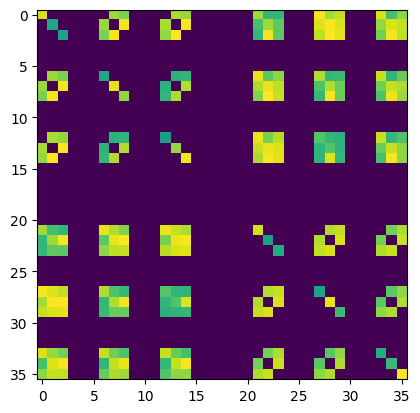

In [18]:
plt.imshow(K[0])

In [8]:
from src.networks.gcn_net_new import GCN_Net 
import torch

gcn_model = GCN_Net(
    channels=(32, 32, 32),
    sk_channels=1,
)
gcn_model = torch.load("../checkpoints/gcn1_model_100.pth")

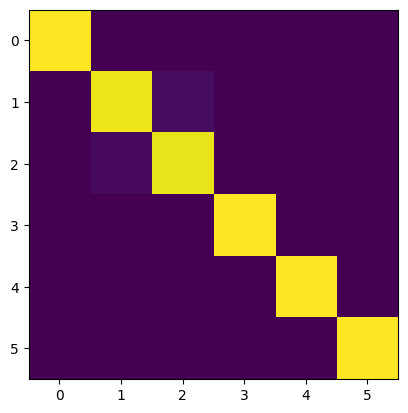

In [19]:
from src.utils.lap import gcn_match


n1 = torch.tensor([ego_preds.shape[1]])
n2 = torch.tensor([cav_preds.shape[1]])
output = gcn_match(K, n1, n2, gcn_model)
plt.imshow(output.detach().numpy()[0])

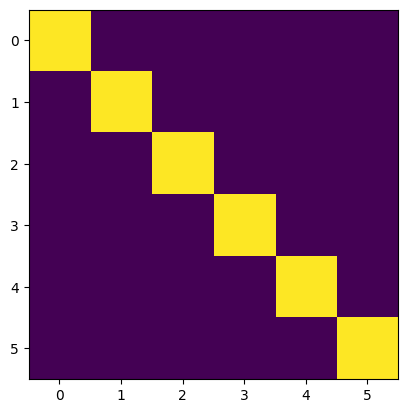

In [20]:
plt.imshow(gt[0].numpy())

In [11]:
def print_model(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'Name:{name}\nShape:{param.shape}\nParams:{param.data}')

In [12]:
print_model(gcn_model)

Name:layers.0.classifier.weight
Shape:torch.Size([1, 32])
Params:tensor([[-0.0589, -0.0063, -0.0399, -0.0124, -0.0034, -0.0194,  0.0009, -0.0052,
         -0.0113,  0.0016, -0.0849, -0.0122,  0.0036, -0.1060, -0.0233,  0.0106,
         -0.0041, -0.0018,  0.0303, -0.0012,  0.0024, -0.0053, -0.0044, -0.0033,
          0.0005, -0.0195, -0.0163, -0.0189, -0.0313,  0.0002, -0.0080, -0.0123]])
Name:layers.0.classifier.bias
Shape:torch.Size([1])
Params:tensor([-0.4390])
Name:layers.0.conv.bias
Shape:torch.Size([32])
Params:tensor([ 0.2340,  0.4493,  0.7182,  0.2281,  0.2219,  0.1873, -0.0385, -0.0252,
         0.3778, -0.2188, -0.5992, -0.2765,  0.6963, -0.4665, -0.3099, -0.2124,
         0.0885,  0.1061, -0.3774,  0.3729, -0.3389, -0.0831,  0.0016,  0.6230,
         0.5119,  0.6870,  0.2345,  0.2810,  0.6062,  0.2853, -0.7522, -0.2688])
Name:layers.0.conv.lin.weight
Shape:torch.Size([32, 1])
Params:tensor([[-1.1582e-01],
        [ 8.0695e-02],
        [ 8.1482e-01],
        [ 5.4515e-01],
  

In [24]:
def pad_affinity_matrix(K: torch.Tensor, max_size: int) -> torch.Tensor:
    """
    将亲和度矩阵 K 填充到固定大小
    
    参数:
        K: 输入亲和度矩阵，维度为 (n1, n2)
        max_size: 目标填充大小
        
    返回:
        padded_K: 填充后的矩阵，维度为 (max_size, max_size)
        n1: 原始维度1
        n2: 原始维度2
    """
    n1, n2 = K.shape
    padded_K = torch.zeros(max_size, max_size, device=K.device)
    
    # 复制原始数据
    padded_K[:n1, :n2] = K
    
    # 对角线填充1，避免影响 GCN 的消息传递
    padded_K[n1:, n2:] = torch.eye(max_size - max(n1, n2), device=K.device)
    
    return padded_K.unsqueeze(0)

def unpad_output(output: torch.Tensor, n1: int, n2: int) -> torch.Tensor:
    """
    从填充后的输出中恢复原始大小的结果
    
    参数:
        output: 模型输出，维度为 (max_size, max_size)
        n1: 原始维度1
        n2: 原始维度2
        
    返回:
        原始大小的输出矩阵
    """
    return output[:n1, :n2]

In [25]:
# 设置最大维度
MAX_SIZE = 100  

# 对输入进行padding
padded_K = pad_affinity_matrix(K[0], MAX_SIZE)

# 使用模型进行预测
padded_output = gcn_match(padded_K, n1, n2, gcn_model)

# 恢复原始维度
output = unpad_output(padded_output, n1[0], n2[0])

# 可视化结果
plt.imshow(output.detach().numpy())

RuntimeError: shape '[6, 6]' is invalid for input of size 100